# Final Project Phase 2 - Home Credit Default Risk

Spring 2024

**Team Members:**
- Glen Colletti
- Alex Bordanca
- Paul Miller

## Abstract
>"The project is based on the [Home Credit Default Risk (HCDR)  Kaggle Competition](https://www.kaggle.com/competitions/home-credit-default-risk/overview). The goal of the competition is to predict whether or not a client will repay a loan. In order to make sure that people who struggle to get loans due to insufficient or non-existent credit histories have a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities."

During this phase of the project the team will accomplish the following tasks:
- Download and load the data from Kaggle.
- Perform exploratory data analysis (EDA).
- Define several baseline classification models using KNN, XG Boost and Logistic Regression. 
- Create pipelines to standardize any numerical feature and one hot encode categorial features.
- Calculate several metrics to evaluate each model and pipeline.
- Record 2 minute video discussing our progress.



In [48]:
from pandas import concat, DataFrame,read_csv, set_option
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from __future__ import print_function

import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from xgboost import XGBClassifier

np.random.seed(0)

# Suppress scientific notation and use 3 decimal places
set_option('display.float_format', '{:.3f}'.format)

All data downloaded from Kaggle:

https://www.kaggle.com/competitions/home-credit-default-risk/data

There are several other data files which contain information regarding a customer's financial profile, payment history etc obtained from Kaggle:
- `bureau.csv`
- `bureau_balance.csv`
- `credit_card_balance.csv`
- `installments_payments.csv`
- `previous_application.csv`
- `POS_CASH_balance.csv`

The baseline pipelines will only use data loaded from `application_train.csv`

In [2]:
train_data = read_csv('data/application_train.csv')

print(f'Loaded {train_data.shape[0]:,} records.')
print()
train_data.head()

Loaded 307,511 records.



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Dictionary

As provided in the Kaggle data.

In [3]:
data_dictionary = read_csv('data/HomeCredit_columns_description.csv')
data_dictionary.head(3)

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN


Display all columns and their descriptions in the application_train and test data.

In [4]:
# Drop first column (an unneeded index)
data_dictionary.drop('Unnamed: 0', axis=1, inplace=True)


set_option('display.max_columns', None)  
set_option('display.max_rows', None)  
set_option('display.max_colwidth', None) 
data_dictionary[data_dictionary['Table'] == 'application_{train|test}.csv']

,Table,Row,Description,Special
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


## Exploratory Data Analysis (EDA)

In [5]:
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [6]:
# NUMERICAL FEATURES
train_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [7]:
# ALL FEATURES
train_data.describe(include='all') 

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Explore missing data in training dataset

In [8]:
#MISSING DATA FOR APPLICATION TRAIN

percent = (train_data.isnull().sum() / train_data.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = train_data.isna().sum().sort_values(ascending = False)
missing_application_train_data  = concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

,Percent,Train Missing Count
COMMONAREA_MEDI,69.87,214865
COMMONAREA_AVG,69.87,214865
COMMONAREA_MODE,69.87,214865
NONLIVINGAPARTMENTS_MODE,69.43,213514
NONLIVINGAPARTMENTS_AVG,69.43,213514
NONLIVINGAPARTMENTS_MEDI,69.43,213514
FONDKAPREMONT_MODE,68.39,210295
LIVINGAPARTMENTS_MODE,68.35,210199
LIVINGAPARTMENTS_AVG,68.35,210199
LIVINGAPARTMENTS_MEDI,68.35,210199


## Correlations

Find the features most correlated to the target. List the 10 most positive and 10 most negative

In [9]:
correlations = train_data.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


Print out most correlated features in list form to use when modeling.

In [10]:
list(correlations[0:10].index)

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'DAYS_EMPLOYED',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'ELEVATORS_AVG']

In [11]:
list(correlations.tail(10).index)

['FLAG_DOCUMENT_3',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_EMP_PHONE',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_BIRTH',
 'TARGET']

In [12]:
most_pos_corr = correlations.tail(11)
most_neg_corr = correlations.head(10)

neg_cols = most_neg_corr.index.to_list()
pos_cols = most_pos_corr.index.to_list()

Check for Multi-Collinearity in the top 20 features

In [13]:
train_data = train_data.sample(10_000) 

In [17]:
train_data[neg_cols + pos_cols].head(10)

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_EMPLOYED,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,ELEVATORS_AVG,DAYS_REGISTRATION,FLAG_DOCUMENT_3,REG_CITY_NOT_LIVE_CITY,FLAG_EMP_PHONE,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH,TARGET,TARGET
42962,0.145543,0.182710,0.484936,-2125,NaN,NaN,NaN,360000.0,0.020246,NaN,-4611.0,1,0,1,0,-4653,-2008.0,3,3,-21774,1,1
227307,0.680139,0.669053,0.624574,-2055,0.6250,0.6250,0.6250,450000.0,0.046220,0.48,-3052.0,1,0,1,0,-2028,-728.0,1,1,-18499,0,0
290035,0.173527,0.454279,NaN,-4159,0.3333,0.3333,0.3333,900000.0,0.010643,0.12,-8525.0,0,0,1,0,-1616,-1273.0,2,2,-18084,0,0
239833,0.440058,0.688145,NaN,-2532,NaN,NaN,NaN,1125000.0,0.018634,NaN,-12304.0,1,0,1,1,-4215,-984.0,2,2,-12319,0,0
76427,0.081726,0.426409,NaN,-2516,0.1667,0.1667,0.1667,675000.0,0.020713,0.00,-2789.0,0,0,1,0,-2834,0.0,3,2,-10151,0,0
305881,0.450747,0.584521,NaN,-878,NaN,NaN,NaN,360000.0,0.018634,NaN,-4818.0,1,0,1,1,-3266,-13.0,2,2,-20176,0,0
222747,0.472253,0.674928,NaN,-3609,NaN,NaN,NaN,463500.0,0.022800,NaN,-7702.0,1,0,1,0,-1878,-431.0,2,2,-18350,0,0
34699,0.358951,0.413630,NaN,-5518,NaN,NaN,NaN,283500.0,0.010966,NaN,-9890.0,1,0,1,0,-3492,-2715.0,2,2,-19979,0,0
116270,0.477649,0.721137,NaN,-4985,0.3333,0.3333,0.3333,2250000.0,0.026392,0.24,-7164.0,1,0,1,0,-4188,-1.0,2,2,-22723,0,0
146605,0.273565,0.618894,NaN,365243,NaN,NaN,NaN,229500.0,0.014520,NaN,-1081.0,1,0,0,0,-4542,-631.0,2,2,-21084,0,0


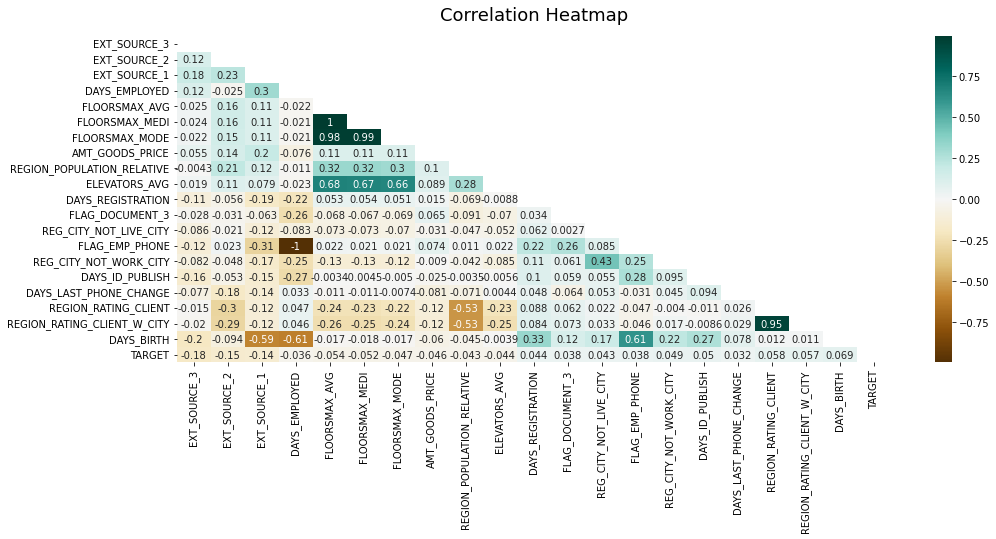

In [67]:
 plt.figure(figsize=(16, 6))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_data[neg_cols + pos_cols].corr(), dtype=bool))

top_20_heatmap = sns.heatmap(train_data[neg_cols + pos_cols].corr(), mask=mask, annot=True, cmap='BrBG')

top_20_heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Inspect loan amount the customer is applying for.

In [55]:
correlations["AMT_CREDIT"]

-0.03036928646142988

In [42]:
train_data["AMT_CREDIT"].describe()

count     10000.000
mean     597156.383
std      401583.058
min       45000.000
25%      270000.000
50%      509400.000
75%      808650.000
max     2931660.000
Name: AMT_CREDIT, dtype: float64

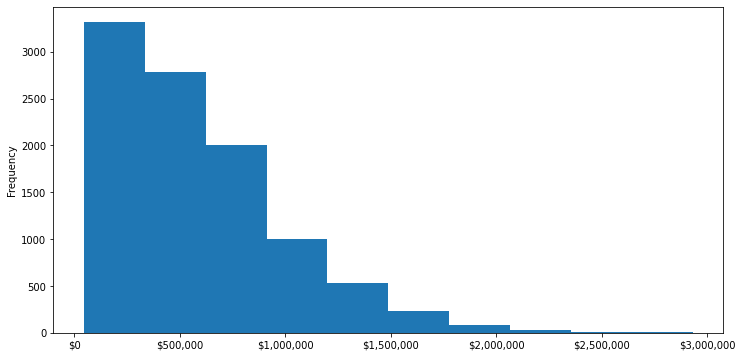

In [53]:
plt.figure(figsize=(12, 6))

ax = plt.gca() 

def format_dollars(x, pos):
    """Format a number in dollars with commas."""
    return "${:,.0f}".format(x)

# Set the x-axis tick formatter to use the custom function
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))

ax.ticklabel_format(axis='y', style='plain')
train_data["AMT_CREDIT"].plot.hist();

In [60]:
train_data['DAYS_EMPLOYED'].describe()

count    10000.000
mean     61961.878
std     139704.104
min     -16364.000
25%      -2746.000
50%      -1207.500
75%       -291.000
max     365243.000
Name: DAYS_EMPLOYED, dtype: float64

In [64]:
# Convert the value counts to a DataFrame
days_employed_counts = train_data['DAYS_EMPLOYED'].value_counts().to_frame().reset_index()

# Rename columns if necessary
days_employed_counts.columns = ['Value', 'Count']

# Sort by Count in descending order
days_employed_counts.sort_values(by='Count', ascending=False)[:20]

,Value,Count
0,365243,1750
1,-741,11
2,-196,9
3,-200,9
7,-219,8
10,-830,8
8,-425,8
9,-351,8
6,-238,8
5,-345,8


Keep only negative values. Day employed = "How many days before the application the person started current employment"

In [68]:
train_data[train_data['DAYS_EMPLOYED'] < 0]['DAYS_EMPLOYED'].describe()

count     8250.000
mean     -2370.481
std       2334.322
min     -16364.000
25%      -3144.750
50%      -1637.000
75%       -751.000
max         -2.000
Name: DAYS_EMPLOYED, dtype: float64

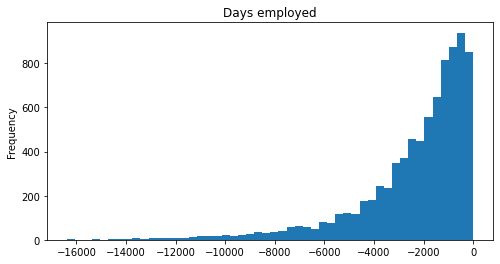

In [70]:
plt.figure(figsize=(8, 4))

ax = plt.gca() 

ax.ticklabel_format(axis='y', style='plain')

plt.title('Days employed')
train_data[train_data['DAYS_EMPLOYED'] < 0]['DAYS_EMPLOYED'].plot.hist(bins=50);

## Visual EDA

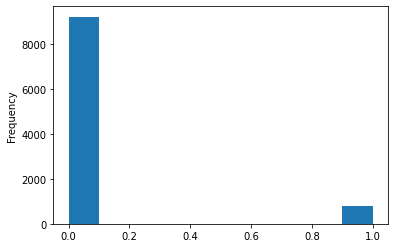

In [60]:
#EXPLORE DISTRIBUTION OF TARGET VARIABLE

train_data["TARGET"].plot.hist();

In [68]:
train_data['TARGET'].value_counts(normalize=True)

0    0.9227
1    0.0773
Name: TARGET, dtype: float64

Inspect features most correlated to the target variable.

In [61]:
most_pos_corr = correlations.tail(11)
most_neg_corr = correlations.head(10)

neg_cols = most_neg_corr.index.to_list()
pos_cols = most_pos_corr.index.to_list()

In [62]:
neg_cols

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'DAYS_EMPLOYED',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'ELEVATORS_AVG']

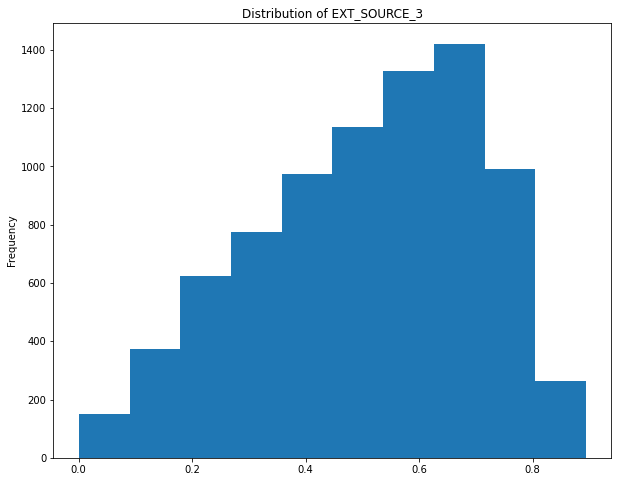

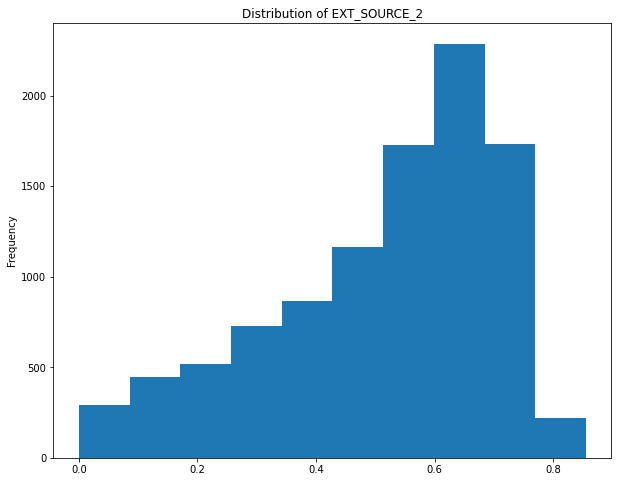

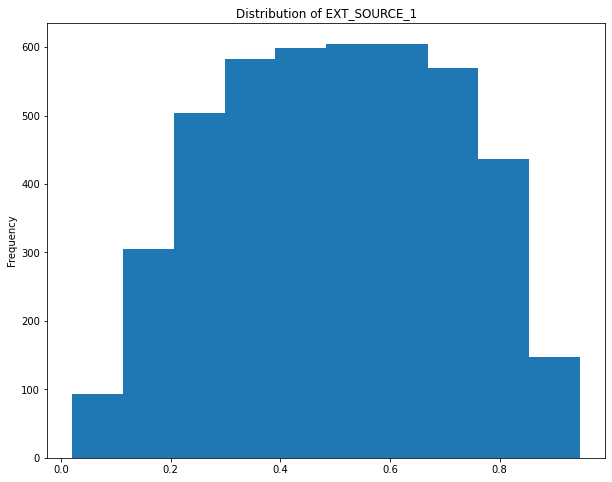

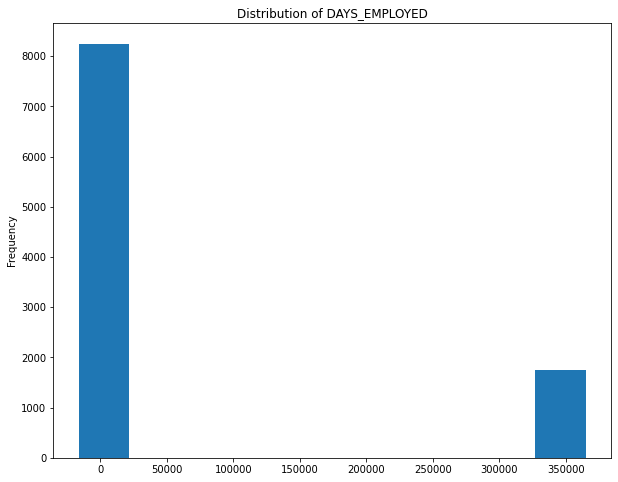

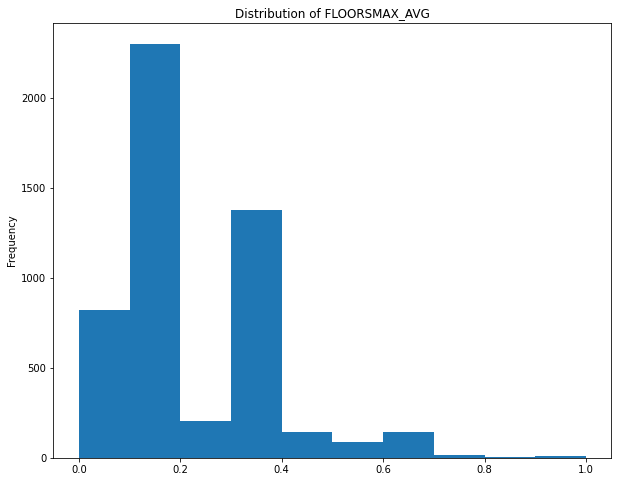

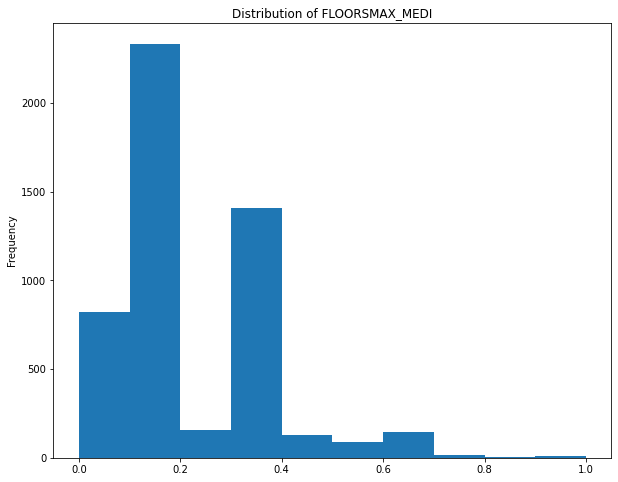

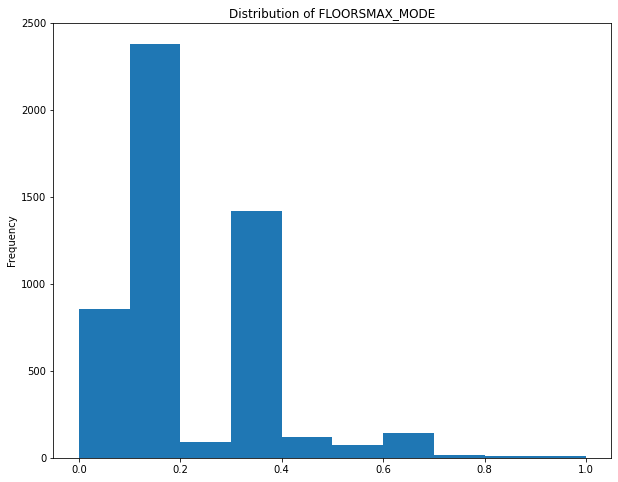

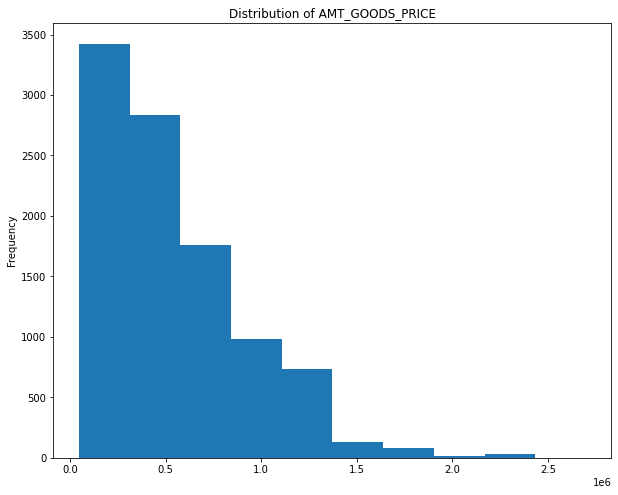

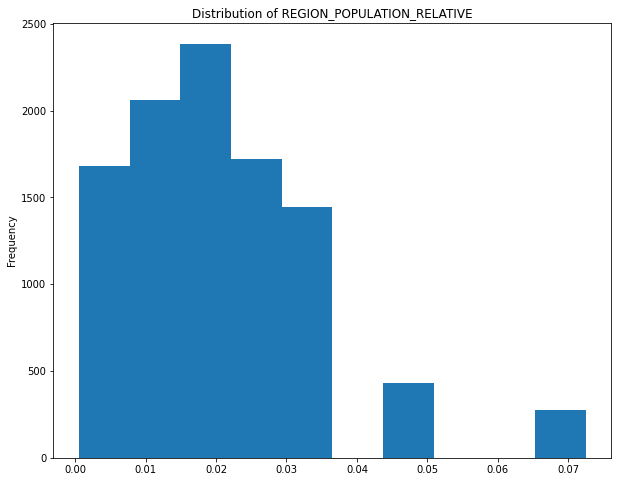

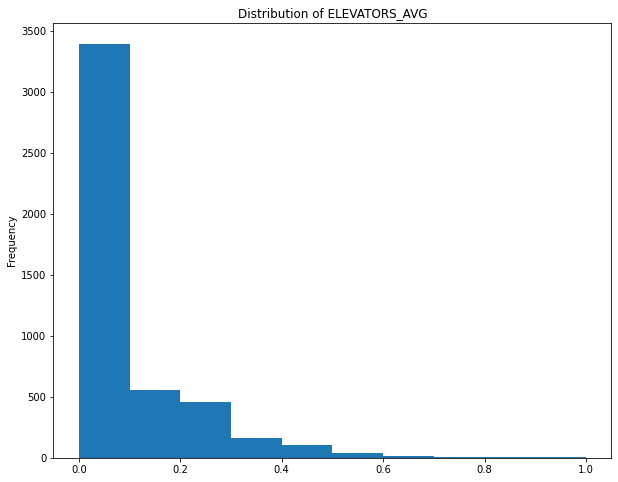

In [64]:
#EXPLORE DISTRIBUTION FOR MOST NEGATIVELY CORRELATED FEATURES

for col in neg_cols:
    plt.figure(figsize=(10,8))
    plt.title(f"Distribution of {col}")
    train_data[col].dropna().plot.hist()

In [65]:
pos_cols

['DAYS_REGISTRATION',
 'FLAG_DOCUMENT_3',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_EMP_PHONE',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_BIRTH',
 'TARGET']

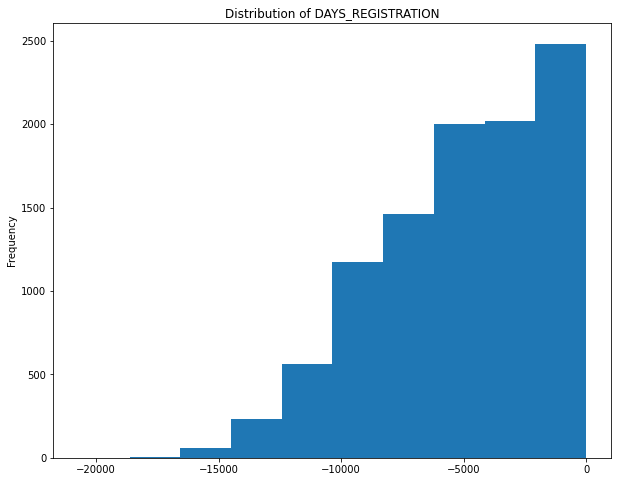

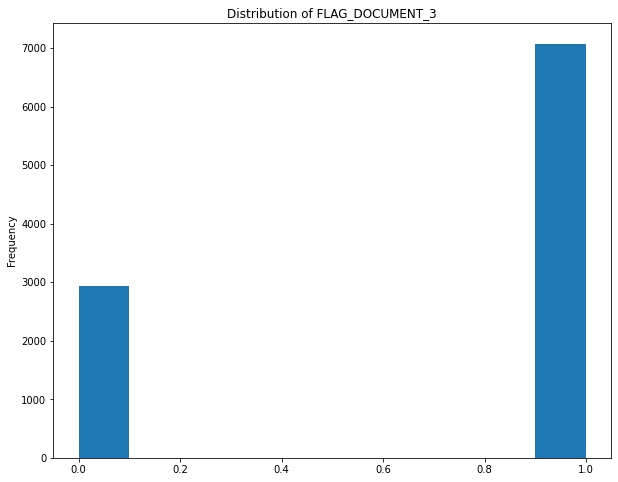

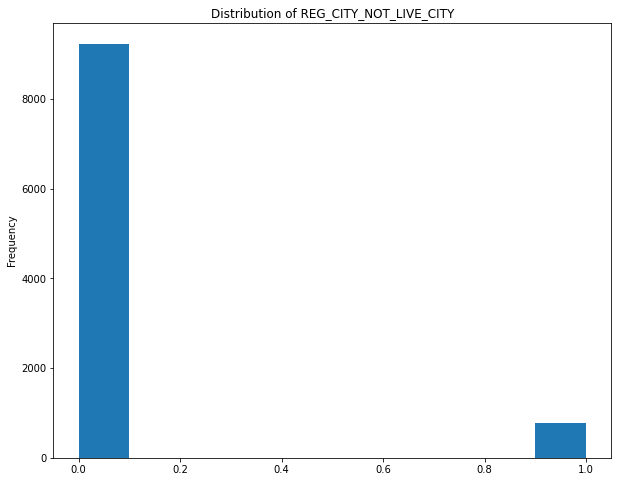

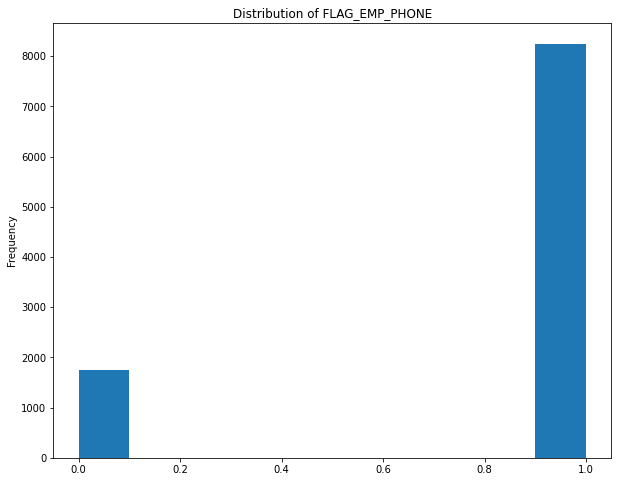

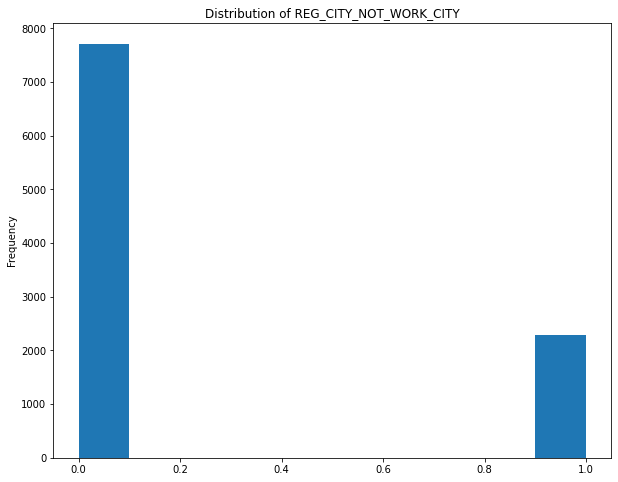

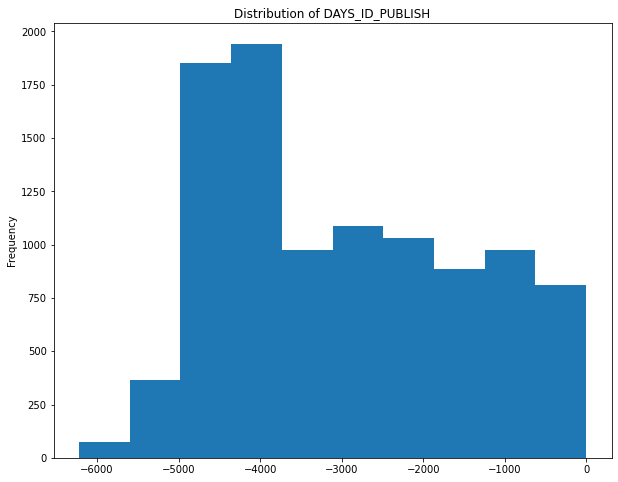

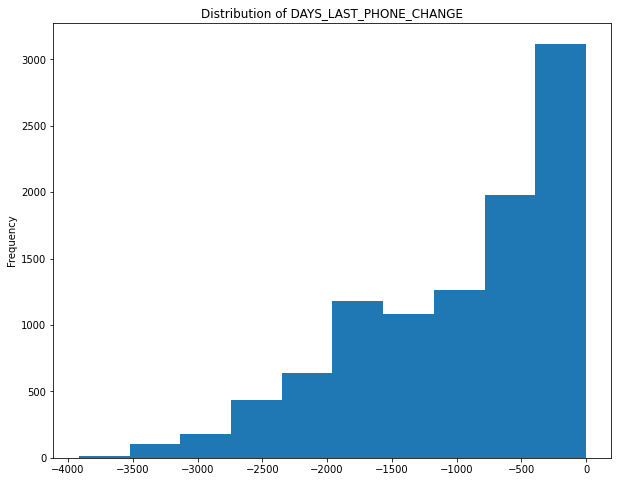

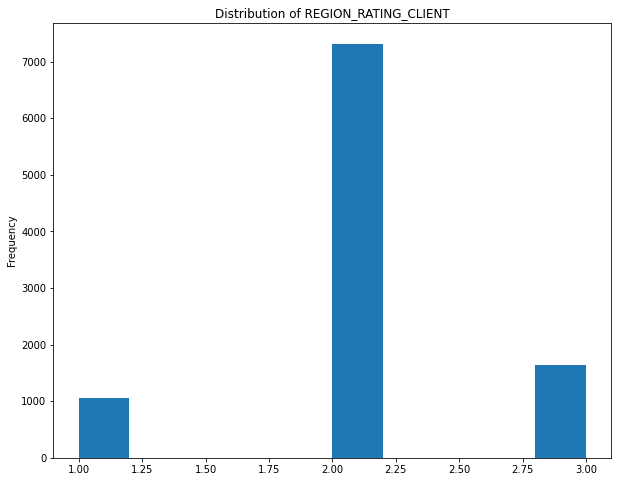

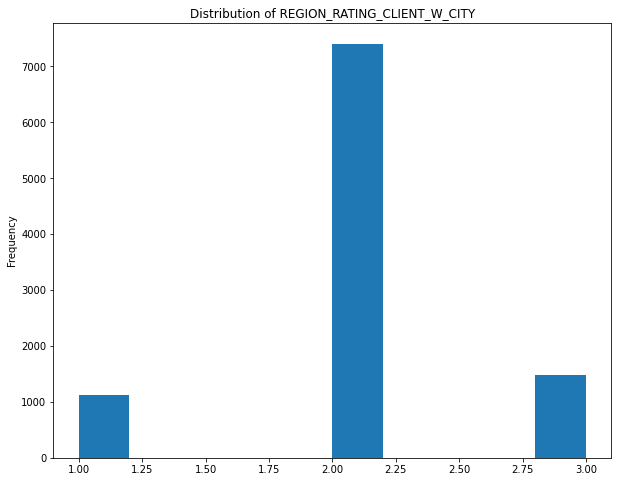

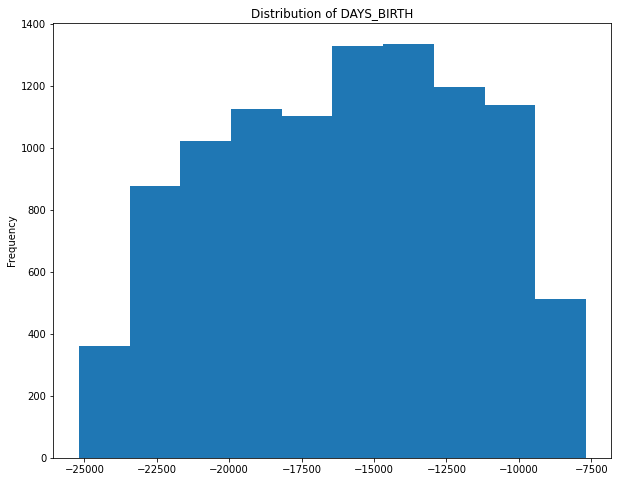

In [66]:
# EXPLORE DISTRIBUTION FOR MOST NEGATIVELY CORRELATED FEATURES

for col in pos_cols[:-1]:
    plt.figure(figsize=(10,8))
    plt.title(f"Distribution of {col}")
    train_data[col].dropna().plot.hist()

# Train, Test, Split data from `application_train.csv`

Initial attempts were crashing kernels because the dataset was too large (over 300,000 records)

We are taking a random sample of 10,000 rows to allow our models to function. Future models may expand the size of the model training set to improve model performance.

In [30]:
# Take random sample of overall training data
train_data = train_data.sample(10_000) 

Create training, validation and testing data.

In [31]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

# Split the provided training data into training and validationa and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")


X_train.head()

X train           shape: (6800, 121)
X validation      shape: (1700, 121)
X test            shape: (1500, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
215244,349412,Cash loans,F,Y,Y,0,117000.0,592560.0,35806.5,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018029,-13483,-547,-7537.0,-4677,0.0,1,1,1,1,1,0,Sales staff,2.0,3,3,TUESDAY,12,0,0,0,0,0,0,Business Entity Type 3,NaN,0.530192,0.456110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-405.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
137066,258971,Cash loans,M,N,Y,0,112500.0,254700.0,16276.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018634,-16345,-4175,-6490.0,-4172,NaN,1,1,1,1,1,0,Laborers,2.0,2,2,SATURDAY,14,0,0,0,0,0,0,Business Entity Type 3,0.177842,0.559699,0.644679,0.2330,0.0952,0.9801,NaN,NaN,0.08,0.0690,0.3333,NaN,0.0790,NaN,0.1046,NaN,0.009,0.2374,0.0988,0.9801,NaN,NaN,0.0806,0.0690,0.3333,NaN,0.0808,NaN,0.1090,NaN,0.0095,0.2352,0.0952,0.9801,NaN,NaN,0.08,0.0690,0.3333,NaN,0.0804,NaN,0.1065,NaN,0.0092,NaN,block of flats,0.1322,"Stone, brick",No,0.0,0.0,0.0,0.0,-422.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
126411,246600,Revolving loans,M,Y,Y,0,153000.0,180000.0,9000.0,180000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.022800,-13813,-254,-4745.0,-4250,7.0,1,1,0,1,0,0,Drivers,2.0,2,2,THURSDAY,13,0,0,0,1,1,0,Business Entity Type 3,0.297692,0.312431,0.190706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-630.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
123541,243271,C

# Pipelines

## KNN Classification

We have included block diagrams detailing each pipeline.

![Image](KnnBlockDiagram.png)


![Image](XGBBlockDiagram.png)


![Image](LogisticRegressionDiagram.png)



In [32]:
numeric_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','OCCUPATION_TYPE']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])


knn_model.fit(X_train, y_train)
print(knn_model.score(X_test, y_test))

0.9133333333333333


Create a log to compare the different models' perfomance.

Code adapted from `HW04-LinRegrBoston_Bike-Demand.ipynb`

In [41]:
try:
    del expLog
except:
    pass

exp_name = "knn_baseline"
try:
    expLog
except NameError:
    expLog = DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train F1", 
                                   "Valid F1",
                                   "Test  F1"
                                  ])

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, knn_model.predict(X_train)), 
                accuracy_score(y_valid, knn_model.predict(X_valid)),
                accuracy_score(y_test, knn_model.predict(X_test)),
                f1_score(y_train, knn_model.predict(X_train)),
                f1_score(y_valid, knn_model.predict(X_valid)),
                f1_score(y_test, knn_model.predict(X_test))],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,knn_baseline,0.9234,0.9282,0.9133,0.0876,0.0,0.058


## XG Boost Pipeline

In [42]:
numeric_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','OCCUPATION_TYPE']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

XGB_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])


XGB_model.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:18:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
       

In [43]:
exp_name = "XGB_baseline"

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, XGB_model.predict(X_train)), 
                accuracy_score(y_valid, XGB_model.predict(X_valid)),
                accuracy_score(y_test, XGB_model.predict(X_test)),
                f1_score(y_train, XGB_model.predict(X_train)),
                f1_score(y_valid, XGB_model.predict(X_valid)),
                f1_score(y_test, XGB_model.predict(X_test))],
    4))

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,knn_baseline,0.9234,0.9282,0.9133,0.0876,0.0000,0.058
1,XGB_baseline,0.9638,0.9300,0.9127,0.7007,0.0165,0.015


## Logistic Regression Pipeline

In [44]:
numeric_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','OCCUPATION_TYPE']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

logreg_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=10000))])


logreg_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
       

In [45]:
exp_name = "logreg_baseline"

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, logreg_model.predict(X_train)), 
                accuracy_score(y_valid, logreg_model.predict(X_valid)),
                accuracy_score(y_test, logreg_model.predict(X_test)),
                f1_score(y_train, logreg_model.predict(X_train)),
                f1_score(y_valid, logreg_model.predict(X_valid)),
                f1_score(y_test, logreg_model.predict(X_test))],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,knn_baseline,0.9234,0.9282,0.9133,0.0876,0.0000,0.058
1,XGB_baseline,0.9638,0.9300,0.9127,0.7007,0.0165,0.015
2,logreg_baseline,0.9216,0.9329,0.9160,0.0000,0.0000,0.000


# Results

All models were trained on the 20 most correlated features of the 120 available in the `application_train.csv`. Future work will add additional features, as well as implemented feature engineering to create new features. 

The baseline models all performed relatively well in predicting an outcome of a customer's default risk in both the validation and test sets in terms of accuracy. However the F1 scores are extremely low for all models. Since the F1 score is a combination of precision and recall, this implies one of those two metrics may be zero.

Precision is defined as 

$$ \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

Recall is defined as

$$ \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$



The target is imbalanced, since 92.2% of the customers did not default. It is possible there are 0 True Positives in the validation and test set.

In [50]:
train_data['TARGET'].value_counts(normalize=True)

0    0.9227
1    0.0773
Name: TARGET, dtype: float64

In [56]:
print (f'The target class is 1 in the validation data: {round(y_valid.sum() / len(y_valid), 4)}')

print (f'The target class is 1 in the test data: {round(y_test.sum() / len(y_test), 4)}')

The target class is 1 in the validation data: 0.0671
The target class is 1 in the test data: 0.084


Of the three trained and fitted models, the XGBoost Classifier performed the best. It was the only model to have an F1 score greater than zero, implying that it did classify correctly at least test record as a true positive.

# Conclusions

The goal of this project is to use the data as provided by Kaggle and predict whether or not a client will repay a loan. The target column contains a 1 if the client does not pay their loan and is a credit risk.

This phase of the project dealt mainly with creating baseline pipelines and models. These model metrics will help guide our future efforts as we perform feature engineering, add and remove features, and use GridSearch to tune model hyperparameters.


Our hypothesis for now is that by using the top twenty features we are able to build an accurate model. However since the data is imbalanced, we may need to use revisit which features to use in the model, or dive deeper into the other data files Kaggle provides.

Our key steps:
- Download and load the data from Kaggle.
- Perform exploratory data analysis (EDA).
- Define several baseline classification models using KNN, XG Boost and Logistic Regression.
- Create pipelines to standardize any numerical feature and one hot encode categorial features.
- Calculate several metrics to evaluate each model and pipeline.


Results are slightly misleading because a high accuracy score does not necessarily imply a quality model. If the model predicts 0 for every record in the test set, it would be correct around 92% of the time. 

Future steps will include further investigation into the various features in the data sets. Checking for multicollinearity may identify issues with feature selection as well. We intend to build a neural network model and compare it's performance to the baseline models above.


# Credit assignment plan

![Image](Phase_2_Credit_Assignment.png)